In [2]:
%load_ext autoreload

# general imports
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.device_schema.device_action_properties import DeviceActionType
import numpy as np

from utils import Plotter, DeviceUtils,BraketTaskScanner,DeviceScanner

# from qiskit.visualization.timeline import draw


In [3]:
#non recursive QFT implementation kindly borrowed by braket examples

@circuit.subroutine(register=True)
def qft(qubits,swaps=True):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the QFT.
    
    Args:
        qubits (int array): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1,num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
    
    if swaps:
        # Then add SWAP gates to reverse the order of the qubits:
        for i in range(math.floor(num_qubits/2)):
            qftcirc.swap(qubits[i], qubits[-i-1])

    return qftcirc



@circuit.subroutine(register=True)
def inverse_qft(qubits,swaps=True):
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (int): The list of qubits on which to apply the inverse QFT
    """
    # instantiate circuit object
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    if swaps:
        # First add SWAP gates to reverse the order of the qubits:
        for i in range(math.floor(num_qubits/2)):
            qftcirc.swap(qubits[i], qubits[-i-1])
        
    # Start on the last qubit and work to the first.
    for k in reversed(range(num_qubits)):
    
        # Apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # These angles are the negative of the angle used in the QFT.
        # Start on the last qubit and iterate until the qubit after k.  
        # When num_qubits==1, this loop does not run.
        for j in reversed(range(1, num_qubits - k)):
            angle = -2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
        # Then add a Hadamard gate
        qftcirc.h(qubits[k])
    
    return qftcirc


# apply id or sigmax to obtain a definite integer as input
# (in binary representation)
@circuit.subroutine(register=True)
def integer_input(qubits, x):
    # instantiate circuit object
    circ = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)

    #must be able to represent input
    assert x < 2**num_qubits
    bitstring = format(x, "0"+ str(num_qubits) +"b")

    #print(bitstring)

    #todo: need to reverse iteration(?)
    for i in range(num_qubits):
        if bitstring[i] == "1" :
            circ.x(qubits[i])


    return circ

#get special state preimage of a defined integer for qft
@circuit.subroutine(register=True)
def transformed_input(qubits, x):

    # get number of qubits
    num_qubits = len(qubits)

    circ = Circuit()

    circ.h(qubits)
    for ii in range(num_qubits - 1):
        circ.rz(ii+1, math.pi/(2**ii))

    return circ




In [8]:


# show inverse QFT example circuit
num_qubits = 3
qubits=range(num_qubits)
my_qft_circ = qft(qubits)
print('QFT CIRCUIT:')
print(my_qft_circ)

# show inverse QFT example circuit
print('')
print('INVERSE-QFT CIRCUIT:')
my_iqft_circ = inverse_qft(qubits)
print(my_iqft_circ)


QFT CIRCUIT:
T  : |0|     1     |      2      |     3     |4| 5  |
                                                     
q0 : -H-PHASE(1.57)-PHASE(0.79)-----------------SWAP-
        |           |                           |    
q1 : ---C-----------|-----------H-PHASE(1.57)---|----
                    |             |             |    
q2 : ---------------C-------------C-----------H-SWAP-

T  : |0|     1     |      2      |     3     |4| 5  |

INVERSE-QFT CIRCUIT:
T  : | 0  |1|     2      |      3       |     4      |5|
                                                        
q0 : -SWAP------------------PHASE(-0.79)-PHASE(-1.57)-H-
      |                     |            |              
q1 : -|------PHASE(-1.57)-H-|------------C--------------
      |      |              |                           
q2 : -SWAP-H-C--------------C---------------------------

T  : | 0  |1|     2      |      3       |     4      |5|


9
Counter({'111111110': 100})


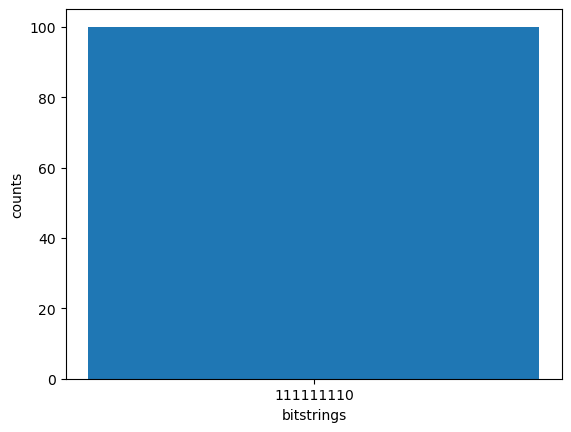

In [4]:
device = LocalSimulator()

x = 0
qbits = 9
print(qbits)

circ = transformed_input(range(qbits), x).qft( range(qbits))

result = device.run(circ, shots = 100).result()

Plotter.plot_binary_results(result, debug=True)

In [91]:
#Rigetti AspenM2
device = DeviceUtils.get_device("rigetti")

qft_task = device.run(circ, shots = 100)



In [117]:
#IonQ
device = DeviceUtils.get_device("ionq")

ion_qft_task = device.run(circ, shots = 100)

ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: [line 10] uses a gate: cphaseshift which is not supported by the device or defined via a defcal

In [47]:
#IonQ
ionQ = DeviceUtils.get_device("ionq")

ion_q_gates = DeviceScanner(device=ionQ).get_supported_gates()
print(ion_q_gates)

['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']


In [65]:
#Lucy
device = DeviceUtils.get_device("oqc")

oqc_qft_task = device.run(circ, shots = 1000)

In [5]:
%load_ext autoreload
%autoreload 2

from utils import BraketTaskScanner


aspen_qft_task = "arn:aws:braket:us-west-1:058017682654:quantum-task/a0f298f3-b2dd-448d-9223-bf1e22305a6a" 
lucy_task = "arn:aws:braket:eu-west-2:058017682654:quantum-task/bc9dacfa-823e-4b8f-81a7-54e51588af99"
aspen_10 = "arn:aws:braket:us-west-1:058017682654:quantum-task/00e27411-115c-404c-b586-2a3c5da198ec"
aspen_8 = "arn:aws:braket:us-west-1:058017682654:quantum-task/14cb4635-c75d-463d-a4e4-c3d74a4e0686"
aspen_6 = "arn:aws:braket:us-west-1:058017682654:quantum-task/3fcb3e03-5eea-407e-89d6-354faf00b160"
aspen_5 = "arn:aws:braket:us-west-1:058017682654:quantum-task/0ea84501-f757-470a-ba40-875bf3b7ee87"
aspen_4 = "arn:aws:braket:us-west-1:058017682654:quantum-task/034cb3e9-0628-440d-a13b-69b453254abd"
aspen_3 = "arn:aws:braket:us-west-1:058017682654:quantum-task/a0f298f3-b2dd-448d-9223-bf1e22305a6a" 
scanner_lucy = BraketTaskScanner(lucy_task)
scanner_aspen = BraketTaskScanner(aspen_8)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Rigetti


0.6500000000
Counter({'0110': 309, '0100': 172, '1110': 97, '1100': 80, '0111': 70, '1010': 45, '1111': 43, '0010': 38, '0101': 34, '1011': 23, '1000': 23, '0011': 21, '0000': 19, '1101': 14, '1001': 8, '0001': 4})


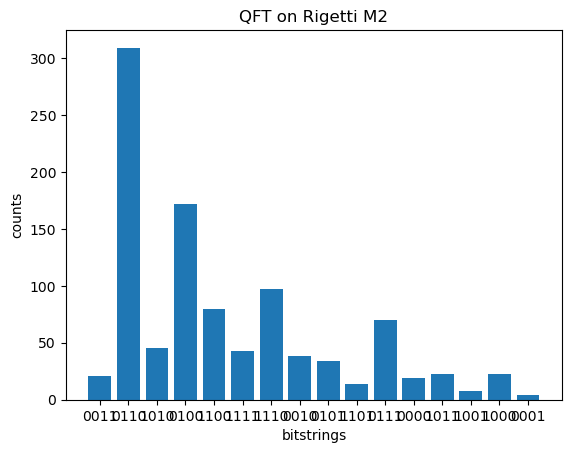

62.5 1000 1000.0 16


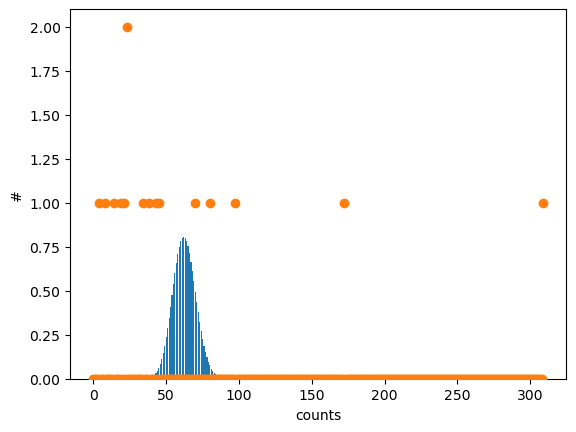

Normalized chi quared for results statistics: 98.0096


False

In [10]:
#print(scanner_aspen.get_circuit())
print(scanner_aspen.cost_extimate())

Plotter.plot_binary_results(scanner_aspen.get_results(), debug=True,title = 'QFT on Rigetti M2')
Plotter.plot_results_statistic(scanner_aspen.get_results())

scanner_aspen.is_garbage()

## Input circuit

In [6]:
#see compiled source for 3 qubits QFT (last significarive one)
scanner_aspen = BraketTaskScanner(aspen_qft_task)

print(scanner_aspen.get_circuit())

OPENQASM 3.0;
bit[3] b;
qubit[3] q;
h q[0];
h q[1];
h q[2];
rz(3.141592653589793) q[1];
rz(1.5707963267948966) q[2];
h q[0];
cphaseshift(1.5707963267948966) q[1], q[0];
cphaseshift(0.7853981633974483) q[2], q[0];
h q[1];
cphaseshift(1.5707963267948966) q[2], q[1];
h q[2];
swap q[0], q[2];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];


## Compiled circuit

In [7]:
print(scanner_aspen.get_compiled_circuit())

DECLARE ro BIT[3]
PRAGMA INITIAL_REWIRING "PARTIAL"
RESET
RZ(-0.1413112636926115) 122
RX(pi/2) 122
RZ(3*pi/2) 122
RZ(pi/2) 135
RX(pi/2) 135
RZ(1.7121075904875074) 135
XY(pi) 135 122
RX(pi/2) 135
RZ(pi/4) 135
RX(-pi/2) 135
XY(pi) 135 122
RZ(-pi/2) 121
RX(pi/2) 121
RZ(5.001919960480251) 121
RZ(-pi/2) 122
RX(pi/2) 122
RZ(1.1399540830067252) 122
RX(-pi/2) 122
RZ(-3*pi/2) 122
XY(pi) 121 122
RX(pi/2) 121
RZ(pi/8) 121
RX(-pi/2) 121
CZ 121 122
RZ(4.83463383653057) 122
RZ(-0.926709427090059) 135
RX(pi/2) 135
RZ(2.3752712447350635) 135
RX(-pi/2) 135
RZ(-3*pi/2) 135
XY(pi) 122 135
RX(pi/2) 122
RZ(pi/4) 122
RX(-pi/2) 122
XY(pi) 122 135
RX(pi/2) 121
RZ(5.600955245385302) 121
RZ(3.122515899047075) 122
CZ 122 121
RZ(pi/2) 121
RZ(-2.228093422063399) 122
RX(pi/2) 122
RZ(pi) 122
RX(-pi/2) 122
RZ(-0.6572970952685027) 122
XY(pi) 121 122
RZ(pi/2) 121
RX(pi/2) 121
RZ(pi/2) 121
RZ(-pi/2) 135
RX(pi/2) 135
RZ(4.731465734927409) 135
MEASURE 122 ro[2]
MEASURE 135 ro[1]
MEASURE 121 ro[0]



In [8]:
#Rigetti produce OpenQASM 3.0 source so we cant plot it with qiskit

from qiskit import  QuantumCircuit
QuantumCircuit().from_qasm_str(scanner_aspen.get_compiled_circuit()).draw()

QasmError: 'Unable to match any token rule, got -->D<-- Check your OPENQASM source and any include statements.'

## OQC

Counter({'010': 19, '000': 18, '110': 18, '100': 12, '101': 12, '011': 10, '111': 6, '001': 5})


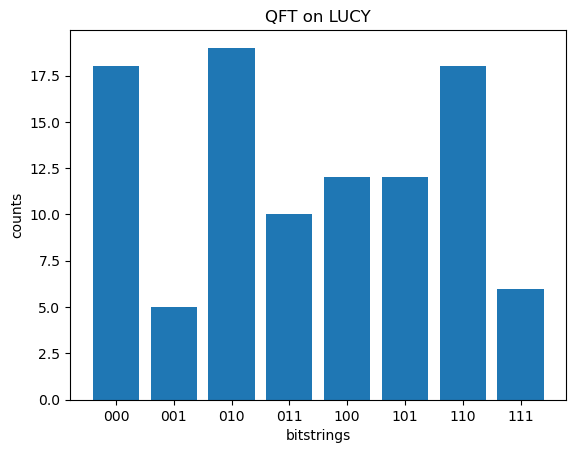

In [30]:
Plotter.plot_binary_results(scanner_lucy.get_results(), debug=True,title = 'QFT on LUCY')

## Input circuit

In [31]:
print(scanner_lucy.get_circuit())

OPENQASM 3.0;
bit[3] b;
qubit[3] q;
h q[0];
h q[1];
h q[2];
rz(3.141592653589793) q[1];
rz(1.5707963267948966) q[2];
h q[0];
cphaseshift(1.5707963267948966) q[1], q[0];
cphaseshift(0.7853981633974483) q[2], q[0];
h q[1];
cphaseshift(1.5707963267948966) q[2], q[1];
h q[2];
swap q[0], q[2];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];


## Compiled circuit

In [32]:
print(scanner_lucy.get_compiled_circuit())

OPENQASM 2.0;
include "qelib1.inc";

qreg node[8];
creg b[3];
h node[0];
u3(3.5*pi,2.75*pi,4.0*pi) node[1];
u3(3.5*pi,2.375000000000001*pi,4.0*pi) node[7];
h node[1];
h node[7];
cx node[0],node[1];
h node[0];
u3(0.0*pi,-0.5*pi,4.25*pi) node[0];
h node[0];
cx node[0],node[1];
h node[0];
h node[1];
u3(0.0*pi,-0.5*pi,0.75*pi) node[0];
u3(0.5*pi,0.0*pi,0.5*pi) node[1];
h node[0];
cx node[0],node[7];
h node[0];
u3(0.0*pi,-0.5*pi,4.375*pi) node[0];
h node[0];
cx node[0],node[7];
h node[0];
u3(0.0*pi,-0.5*pi,0.625*pi) node[0];
h node[0];
cx node[0],node[7];
h node[0];
h node[7];
cx node[0],node[7];
h node[0];
h node[7];
cx node[0],node[7];
h node[0];
h node[7];
measure node[7] -> b[2];
cx node[0],node[1];
u3(0.0*pi,-0.5*pi,4.25*pi) node[1];
cx node[0],node[1];
measure node[1] -> b[1];
u3(0.5*pi,0.0*pi,0.5*pi) node[0];
measure node[0] -> b[0];



In [33]:
from qiskit import  QuantumCircuit
QuantumCircuit().from_qasm_str(scanner_lucy.get_compiled_circuit()).draw()

┌───┐                   ┌───┐┌───────────────────┐┌───┐     »
node_0: ────────┤ H ├────────────────■──┤ H ├┤ U3(0,-π/2,13.352) ├┤ H ├──■──»
        ┌───────┴───┴───────┐ ┌───┐┌─┴─┐└───┘└───────────────────┘└───┘┌─┴─┐»
node_1: ┤ U3(7π/2,11π/4,4π) ├─┤ H ├┤ X ├───────────────────────────────┤ X ├»
        └───────────────────┘ └───┘└───┘                               └───┘»
node_2: ────────────────────────────────────────────────────────────────────»
                                                                            »
node_3: ────────────────────────────────────────────────────────────────────»
                                                                            »
node_4: ────────────────────────────────────────────────────────────────────»
                                                                            »
node_5: ────────────────────────────────────────────────────────────────────»
                                                                            »
node_6: ────────────────────────────────────────────────────────────────────»
        ┌────────────────────┐┌───┐                                         »
node_7: ┤ U3(7π/2,7.4613,4π) ├┤ H ├─────────────────────────────────────────»
        └────────────────────┘└───┘                                         »
   b_0: ════════════════════════════════════════════════════════════════════»
                                                                            »
   b_1: ════════════════════════════════════════════════════════════════════»
                                                                            »
   b_2: ════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌───┐┌─────────────────┐┌───┐     ┌───┐┌───────────────────┐┌───┐     »
«node_0: ┤ H ├┤ U3(0,-π/2,3π/4) ├┤ H ├──■──┤ H ├┤ U3(0,-π/2,13.744) ├┤ H ├──■──»
«        ├───┤└┬───────────────┬┘└───┘  │  └───┘└───────────────────┘└───┘  │  »
«node_1: ┤ H ├─┤ U3(π/2,0,π/2) ├────────┼───────────────────────────────────┼──»
«        └───┘ └───────────────┘        │                                   │  »
«node_2: ───────────────────────────────┼───────────────────────────────────┼──»
«                                       │                                   │  »
«node_3: ───────────────────────────────┼───────────────────────────────────┼──»
«                                       │                                   │  »
«node_4: ───────────────────────────────┼───────────────────────────────────┼──»
«                                       │                                   │  »
«node_5: ───────────────────────────────┼───────────────────────────────────┼──»
«                                       │                                   │  »
«node_6: ───────────────────────────────┼───────────────────────────────────┼──»
«                                     ┌─┴─┐                               ┌─┴─┐»
«node_7: ─────────────────────────────┤ X ├───────────────────────────────┤ X ├»
«                                     └───┘                               └───┘»
«   b_0: ══════════════════════════════════════════════════════════════════════»
«                                                                              »
«   b_1: ══════════════════════════════════════════════════════════════════════»
«                                                                              »
«   b_2: ══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌───┐┌─────────────────┐┌───┐     ┌───┐     ┌───┐     ┌───┐     »
«node_0: ┤ H ├┤ U3(0,-π/2,5π/8) ├┤ H ├──■──┤ H ├──■──┤ H ├──■──┤ H ├──■──»
«        └───┘└─────────────────┘└───┘  │  └───┘  │  └───┘  │  └───┘┌─┴─┐»
«node_1: ───────────────────────────────┼─────────┼─────────┼───────┤ X ├»
«                                       │         │        